# FAST-UAV - Multirotor Design Optimization with Off-The-Shelf components

In this notebook, we will see how to achieve a design optimization using real off-the-shelf components instead of estimation models.

## 1. Setting up a problem with off-the-shelf components

In [1]:
import os.path as pth
import openmdao.api as om
import logging
import shutil
import fastoad.api as oad
from time import time
import matplotlib.pyplot as plt
from utils.drivers.cmaes_driver import CMAESDriver
import cma
from utils.postprocessing.analysis_and_plots import *

plt.rcParams["figure.figsize"]=16,8
plt.rcParams.update({'font.size': 13})

DATA_FOLDER_PATH = "data"
WORK_FOLDER_PATH = "workdir"

# For having log messages display on screen
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

# For using all screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

D:\Softwares\Anaconda3\envs\OAD\lib\site-packages\pyoptsparse\pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


The changes in the model rely in the use of catalogues instead of continuous estimation models to select the components. This is described in the configuration file by the `use_catalogue` option when defining the model:

```yaml
model:
    Core:
        scenarios:
            id: multirotor.sizing_scenarios
        propeller:
            id: propeller
            use_catalogue: true
```

You can check with the N2 diagram visualization that the 'catalogue' module has replaced the 'no_catalogue' module for components where the option has been set to True.

In [2]:
CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH, 'multirotor_mdo_discrete.yaml')
N2_FILE = pth.join(WORK_FOLDER_PATH, 'n2.html')
oad.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width='100%', height='500px')

INFO    : N2 diagram written in D:\THESE\Tools\FAST-ODD\workdir\n2.html


Now, the problem outputs from the design optimization in the continuous domain will be re-used as an initial guess for the optimization in the discrete domain.

In [3]:
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, 'problem_outputs_DJI_M600_mdo.xml')  # re-use continuous optimization results as initial point.
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

INFO    : Loaded variable descriptions in D:\THESE\Tools\FAST-ODD\data\../models
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models
INFO    : Installed bundle models (ID 194 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Missions
INFO    : Installed bundle Missions.mission_design (ID 197 )
INFO    : Installed bundle Missions (ID 195 )
INFO    : Installed bundle Missions.mission_concordia (ID 196 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Scenarios
INFO    : Installed bundle Scenarios.atmosphere (ID 200 )
INFO    : Installed bundle Scenarios (ID 198 )
INFO    : Installed bundle Scenarios.architecture (ID 199 )
INFO    : Installed bundle Scenarios.sizing_scenarios (ID 201 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/System
INFO    : Installed bundle System (ID 202 )
INFO    : Installed bundle System.system (ID 203 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Prop

'D:\\THESE\\Tools\\FAST-ODD\\workdir\\problem_inputs_discrete.xml'

In [4]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_inputs_discrete.xml')
oad.variable_viewer(INPUT_FILE)

## 3. Multirotor MDO with off-the-shelf components

Due to the non-continuous nature of the selection process, the use of a gradient-based algorithm is risky. We therefore recommend the use of an evolutionary algorithm, [CMA-ES](http://www.cmap.polytechnique.fr/~nikolaus.hansen/cmaesintro.html).

### a) Using a gradient-based algorithm: SLSQP

In [5]:
optim_problem = oad.optimize_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Loaded variable descriptions in D:\THESE\Tools\FAST-ODD\data\../models
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models
INFO    : Installed bundle models (ID 194 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Missions
INFO    : Installed bundle Missions.mission_design (ID 197 )
INFO    : Installed bundle Missions (ID 195 )
INFO    : Installed bundle Missions.mission_concordia (ID 196 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Scenarios
INFO    : Installed bundle Scenarios.atmosphere (ID 200 )
INFO    : Installed bundle Scenarios (ID 198 )
INFO    : Installed bundle Scenarios.architecture (ID 199 )
INFO    : Installed bundle Scenarios.sizing_scenarios (ID 201 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/System
INFO    : Installed bundle System (ID 202 )
INFO    : Installed bundle System.system (ID 203 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Prop

Optimization terminated successfully    (Exit mode 0)
            Current function value: [1.48455295]
            Iterations: 8
            Function evaluations: 9
            Gradient evaluations: 8
Optimization Complete
-----------------------------------


### b) Using an evolutionnary strategy: CMA-ES
The [pycma](https://github.com/CMA-ES/pycma) implementation of CMA-ES is used. The optimizer is wrapped with a modified version of the [OpenMDAO driver](https://github.com/OpenMDAO/RevHack2020/tree/master/problems/cma_es).<br>

*Note that the use of custom-made drivers is not supported yet by FAST-OAD. Consequently, the setup and run of the problem is made by hand.*

INFO    : Loaded variable descriptions in D:\THESE\Tools\FAST-ODD\data\../models
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models
INFO    : Installed bundle models (ID 194 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Missions
INFO    : Installed bundle Missions.mission_design (ID 197 )
INFO    : Installed bundle Missions (ID 195 )
INFO    : Installed bundle Missions.mission_concordia (ID 196 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Scenarios
INFO    : Installed bundle Scenarios.atmosphere (ID 200 )
INFO    : Installed bundle Scenarios (ID 198 )
INFO    : Installed bundle Scenarios.architecture (ID 199 )
INFO    : Installed bundle Scenarios.sizing_scenarios (ID 201 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/System
INFO    : Installed bundle System (ID 202 )
INFO    : Installed bundle System.system (ID 203 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Prop

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 11 (seed=991883, Fri Apr  1 12:15:34 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 4.733373097757601e+05 1.0e+00 9.46e-02  9e-02  1e-01 0:00.1
    2     22 1.843053916509940e+05 1.2e+00 8.84e-02  8e-02  9e-02 0:00.2
    3     33 3.640290605562705e+05 1.2e+00 8.33e-02  7e-02  9e-02 0:00.3
   34    374 1.358117502309777e+05 5.0e+00 3.80e-02  1e-02  5e-02 0:03.3
   76    836 2.767236976425018e+04 1.7e+01 6.90e-03  6e-04  8e-03 0:07.3
  100   1100 3.287860399091821e+03 5.9e+01 2.05e-02  2e-03  5e-02 0:09.7
  161   1771 1.657980089604206e+00 2.0e+02 1.23e-02  5e-04  3e-02 0:15.7
  200   2200 1.645732954199387e+00 1.7e+02 6.57e-03  2e-04  1e-02 0:19.4
  281   3091 1.640463373916908e+00 1.3e+02 2.56e-03  5e-05  4e-03 0:27.5
  300   3300 1.639387597618034e+00 1.2e+02 1.50e-03  3e-05  2e-03 0:30.1
  370   4070 1.631926173018417e+00 2.8e+02 5.95e-03  1e-04  1e-02 0:40.1
  400   4400 1.630516387465993e+0

C:\Users\f.pollet.ISAE-SUPAERO\AppData\Roaming\Python\Python38\site-packages\cma\utilities\utils.py:343: UserWarning:

CAVE: restart_from_best is often not useful ()



    1  17040 4.112817986019730e+05 1.0e+00 9.76e-02  9e-02  1e-01 0:00.2
    2  17062 1.917116589106354e+05 1.3e+00 9.60e-02  8e-02  1e-01 0:00.4
    3  17084 1.874106597138669e+05 1.4e+00 1.00e-01  8e-02  1e-01 0:00.6
   20  17458 1.782189793035955e+05 5.9e+00 6.60e-02  2e-02  8e-02 0:03.7
   44  17986 1.691038595040708e+00 2.9e+01 2.22e-02  2e-03  3e-02 0:07.8
   73  18624 1.554580960702070e+00 9.6e+01 1.68e-02  6e-04  2e-02 0:13.0
  100  19218 1.516438723095760e+00 1.5e+02 1.22e-02  2e-04  2e-02 0:17.8
  137  20032 1.504028584656556e+00 2.2e+02 7.78e-03  9e-05  1e-02 0:24.9
  177  20912 1.492167862768858e+00 2.0e+02 1.42e-02  2e-04  3e-02 0:33.0
  200  21418 1.490087754053272e+00 2.8e+02 1.03e-02  1e-04  3e-02 0:37.9
  251  22540 1.487852306132252e+00 5.4e+02 7.93e-03  1e-04  2e-02 0:48.1
  300  23618 1.487008433975571e+00 1.0e+03 1.53e-02  2e-04  4e-02 0:57.2
  365  25048 1.485959433945325e+00 3.0e+03 9.75e-03  8e-05  3e-02 1:09.3
  400  25818 1.485675345764578e+00 6.6e+03 1.48e-02

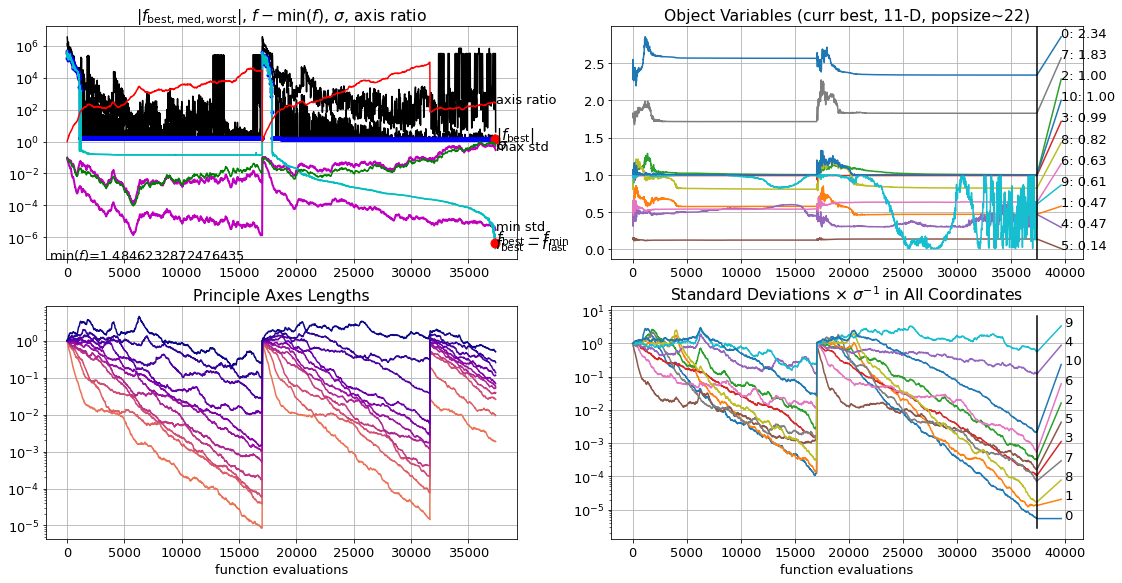

In [14]:
# Get problem configuration
conf = oad.FASTOADProblemConfigurator(CONFIGURATION_FILE)
prob = conf.get_problem(read_inputs=True, auto_scaling=True)

# CMA-ES Driver setup (see cma.CMAOptions() for all possible options for CMA-ES)
driver = prob.driver = CMAESDriver()
driver.options['sigma0'] = 0.1
driver.options['penalty_parameter'] = 1.e6  # should be chosen such that f and the constraints violation have a similar magnitude.
driver.options['penalty_exponent'] = 1.
driver.options['restarts'] = 1
driver.options['restart_from_best'] = True
driver.options['bipop'] = False
driver.CMAOptions['tolfun'] = 1e-6
driver.CMAOptions['tolfunhist'] = 1e-5
driver.CMAOptions['popsize_factor'] = 1
#driver.CMAOptions['CMA_stds'] = [1, 1, 100, 0.1, 0.1, 1, 1, 1, 1]
#driver.CMAOptions['CSA_dampfac'] = 1.  # positive multiplier for step-size damping
#driver.CMAOptions['CSA_squared'] = True
#driver.CMAOptions['integer_variables'] = [2]
#driver.options['augmented_lagrangian'] = True  # whether to use penalty method or augmented lagrangian for handling constraints

# Setup and run problem
prob.setup()
start_time = time()
prob.optim_failed = prob.run_driver()  # optimize 
end_time = time()
computation_time = round(end_time - start_time, 2)
prob.write_outputs()

print("Objective function value ", driver.get_objective_values())

logger = cma.plot()  # plot logger

Let's save and visualize the optimization results:

In [8]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs_discrete.xml")
DJI_M600_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, 'problem_outputs_discrete_DJI_M600_mdo.xml')
shutil.copy(OUTPUT_FILE, DJI_M600_OUTPUT_FILE)
oad.optimization_viewer(CONFIGURATION_FILE)

In [9]:
oad.variable_viewer(OUTPUT_FILE)

## 3. Analysis and plots

We may now compare the results from the optimization in the continuous domain with the off-the-shelf configuration:

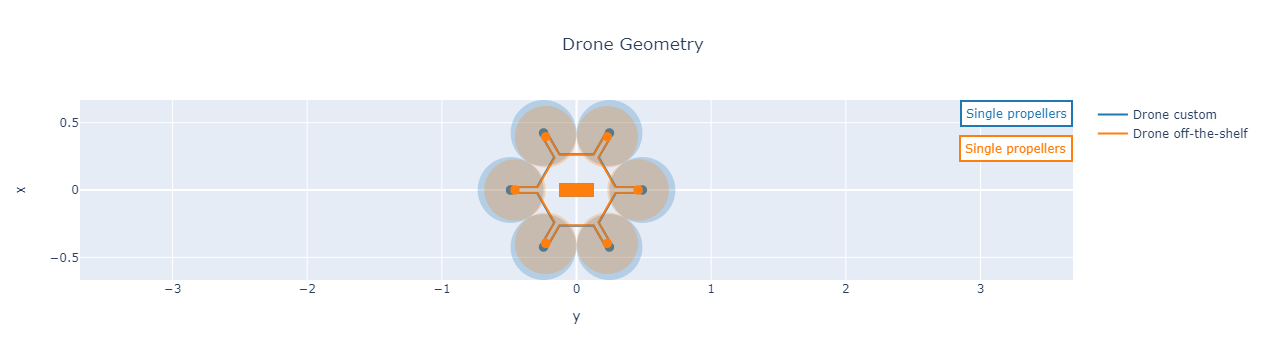

In [10]:
OUTPUT_FILE_CONTINUOUS = pth.join(DATA_FOLDER_PATH, 'problem_outputs_DJI_M600_mdo.xml')
OUTPUT_FILE_DISCRETE = pth.join(DATA_FOLDER_PATH, 'problem_outputs_discrete_DJI_M600_mdo.xml')
fig = multirotor_geometry_plot(OUTPUT_FILE_CONTINUOUS, name='Drone custom')
fig = multirotor_geometry_plot(OUTPUT_FILE_DISCRETE, name='Drone off-the-shelf', fig=fig)
fig.show()

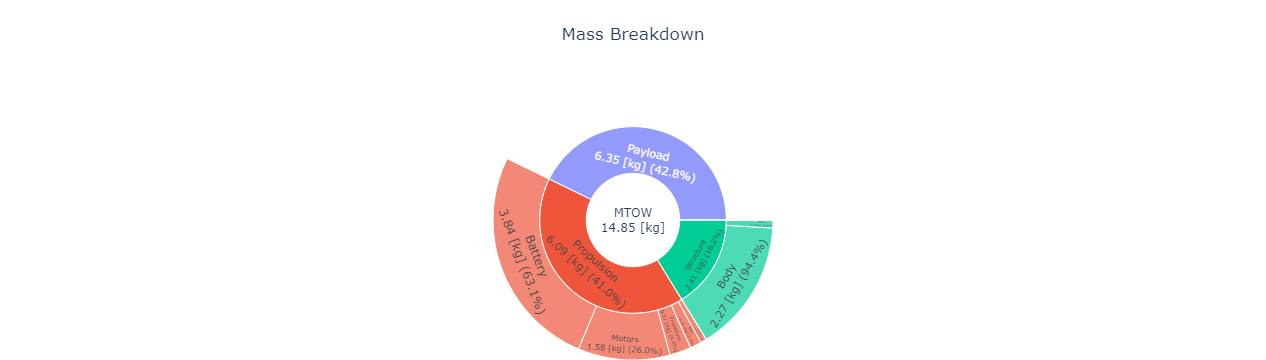

In [11]:
fig = mass_breakdown_sun_plot_drone(OUTPUT_FILE_DISCRETE)
fig.show()

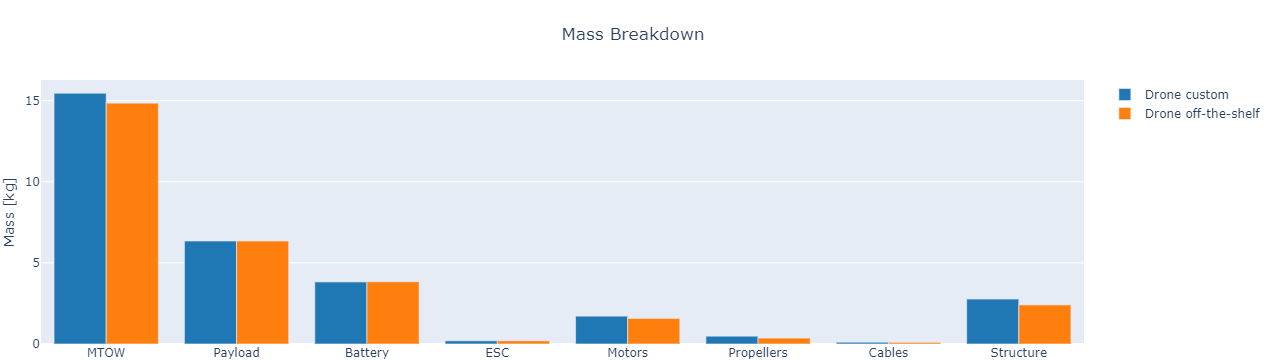

In [12]:
fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE_CONTINUOUS, name='Drone custom')
fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE_DISCRETE, name='Drone off-the-shelf', fig=fig)
fig.show()

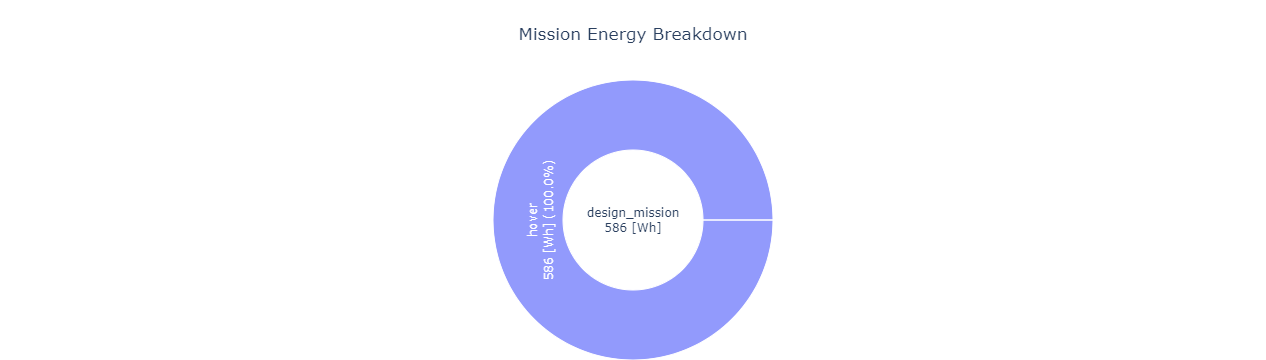

In [13]:
fig = energy_breakdown_sun_plot_drone(OUTPUT_FILE_DISCRETE)
fig.show()